1. Import necessary libraries and PORT-EK source code:

In [108]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
import pathlib
import pickle
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from Bio import SeqIO, Align
from matplotlib import cm, colormaps
from scipy.stats import pearsonr
from scipy.signal import find_peaks
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
82098


2. Declare data set specific definitions and functions:

In [194]:
# PORT-EK parameters
k = 11  # This is the length of k-mers
c = 0.19  # This is the conservation thershold used in k-mer rarity filter
m = 1  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.5  # This is the RMSE threshold used to select enriched k-mers

# Relative path to k-mer indices
INPUT_PATH = "../output/HIV/scenario4"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.
SAMPLE_GROUPS = ["M", "nonM"]
SAMPLE_SUBTYPES = ["MA", "MB", "MC", "MD", "Mrest", "N", "O", "P"]
SUBTYPE_TO_GROUP = {"MA":"M", "MB":"M", "MC":"M", "MD":"M", "Mrest":"M", "N":"nonM", "O":"nonM", "P":"nonM"}

FREQ_COLS = [f"{group}_freq" for group in SAMPLE_GROUPS]
SUB_FREQ_COLS = [f"{group}_freq" for group in SAMPLE_SUBTYPES]

AVG_COLS = [f"{group}_avg" for group in SAMPLE_GROUPS]
SUB_AVG_COLS = [f"{group}_avg" for group in SAMPLE_SUBTYPES]

VOLCANO_CMAP = {
    "not_significant": ("#DDDDDD", 0.5),
    "M_enriched": ("#ffa401", 1),
    "nonM_enriched": ("#005ff5", 1),
}

HIV_GENES = {
    "5' LTR": [(1, 634)],
    "gag": [(789, 2289)],
    "pol": [(2084, 5093)],
    "vif": [(5040, 5616)],
    "vpr": [(5558, 5846)],
    "tat": [(5830, 6045), (8378, 8466)],
    "rev": [(5969, 6045), (8378, 8650)],
    "vpu": [(6061,6307)],
    "env": [(6224, 8792)],
    "nef": [(8796, 9414)],
    "3' LTR": [(9086, 9719)],
}

ref_seq = SeqIO.read("../input/HXB2.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(
    # match_score=5,
    # mismatch_score=-4,
    # open_gap_score=-4,
    # extend_gap_score=-4,
    scoring="megablast",
    mode="local"
)


def assign_gene_from_interval(ref_pos: list, gene_dict: dict) -> str:
    genes = []
    for start, end in ref_pos:
        for gene, gene_ranges in gene_dict.items():
            for gene_range in gene_ranges:
                if (
                    len(
                        [
                            pos
                            for pos in range(start, end + 1)
                            if pos in list(range(gene_range[0], gene_range[1] + 1))
                        ]
                    )
                    > 0
                ):
                    genes.append(gene)

    return ", ".join(genes)

def assign_gene_from_position(ref_pos: int, gene_dict: dict) -> str:
    genes = []
    for gene, gene_ranges in gene_dict.items():
        for gene_range in gene_ranges:
            if gene_range[0] < ref_pos < gene_range[1]:
                genes.append(gene)
    return ", ".join(genes)

3. Construct k-mer count matrix and apply rarity filter

In [7]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than growing the matrix one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*_{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)
sample_list.sort()

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
subtype_sample_idx = {f"{subtype}": [sample for sample in sample_list if sample.split("_")[0] == f"{subtype}"] for subtype in SAMPLE_SUBTYPES}
group_sample_idx = {f"{group}":[] for group in SAMPLE_GROUPS}
for sample in sample_list:
    if "M" in sample.split("_")[0]:
        group_sample_idx["M"].append(sample)
    else:
        group_sample_idx["nonM"].append(sample)
print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")




Imported 1240578 kmers and 15295 samples.


In [8]:

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"{counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: portek.decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
for group in SAMPLE_GROUPS:
    all_kmer_matrix[f"{group}_freq"] = bin_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
    all_kmer_matrix[f"{group}_avg"] = all_kmer_matrix.loc[:, group_sample_idx[group]].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as its presence and count is mostly dependant on sequencing quality not viral variant.
if k*"A" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop(k*"A")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)

15295 of 15295 indices done.
19304 common k-mers remaining after filtering at a threshold of 0.19.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [9]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["seq"] = common_kmer_matrix.index
ERR_COLS = []
P_COLS = []
for j in range(1, len(SAMPLE_GROUPS)):
    for i in range(j):
        err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
        p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
        ERR_COLS.append(err_name)
        P_COLS.append(p_name)
        common_kmer_matrix[err_name] = (
            common_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
            - common_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
        )
        common_kmer_matrix[p_name] = common_kmer_matrix["seq"].apply(
            portek.calc_kmer_pvalue,
            args=(
                group_sample_idx[SAMPLE_GROUPS[i]],
                group_sample_idx[SAMPLE_GROUPS[j]],
                common_kmer_matrix,
            ),
        )
        common_kmer_matrix[f"-log10_{p_name}"] = -np.log10(common_kmer_matrix[p_name])
common_kmer_matrix["RMSE"] = np.sqrt(((common_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))


common_kmer_matrix = common_kmer_matrix.sort_values("RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(
    portek.assign_kmer_group_ava, p_cols = P_COLS, avg_cols = AVG_COLS,axis=1
)
common_kmer_matrix["exclusivity"] = common_kmer_matrix.apply(
    portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [10]:
# common_kmer_matrix.to_csv(f"../output/HIV/scenario4/common_{k}mer_count_matrix.csv")
# common_kmer_stat_matrix.to_csv(f"../output/HIV/scenario4/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/HIV/scenario4/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f"../output/HIV/scenario4/common_{k}mer_count_matrix.csv", index_col=0)
# common_kmer_stat_matrix  = pd.read_csv(f"../output/HIV/scenario4/common_{k}mer_stat_matrix2.csv", index_col=0)
# all_kmer_matrix= pd.read_csv(f"../output/HIV/scenario4/all_{k}mer_count_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

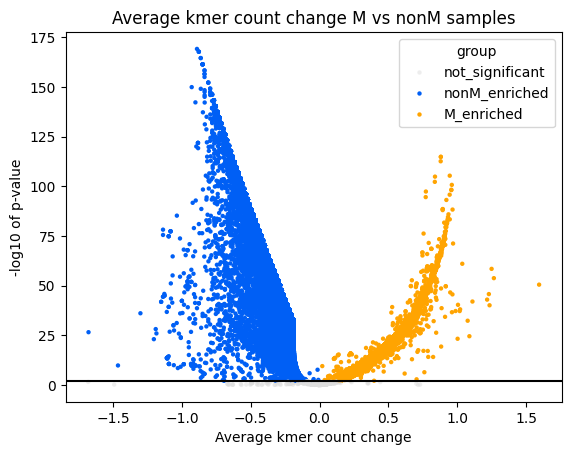

In [11]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.autoscale()
ax.set_title('Average kmer count change M vs nonM samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='M-nonM_err', y = '-log10_M-nonM_p-value', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
plt.savefig(f"../output/HIV/scenario4/{k}_volcano.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [12]:
# Select all rare k-mers that have higher average count in M, no matter the statistical significance.
# common_overrep_kmers = {}
# for group in SAMPLE_GROUPS:
#     common_overrep_kmers[group] = common_kmer_matrix.loc[common_kmer_matrix["group"] == f"{group}_enriched"].index

# rare_overrep_kmers = {}
# for group in SAMPLE_GROUPS:
#     rare_overrep_kmers[group] = all_kmer_matrix.loc[all_kmer_matrix[f"{group}_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1)].index
#     rare_overrep_kmers[group] = rare_overrep_kmers[group].difference(common_overrep_kmers[group])

# rare_overrep_kmers

In [13]:
# Comment the following line to avoid lengthy k-mer similarity graphs calculation
# similarity_graphs = {}
# for group in SAMPLE_GROUPS:
#     similarity_graphs[group] = portek.build_similarity_graph_two_list(
#         common_overrep_kmers[group].tolist(), rare_overrep_kmers[group].tolist(), m
#     )

# # Uncomment the first of the following blocks to save the graphs as pickle file. Uncomment the second to load previously calculated graphs.
# with open(f"../output/HIV/scenario4/{k}mer_{m}m_similarity_graphs.pickle", mode = "wb") as out_file:
#     pickle.dump(similarity_graphs, out_file)



In [14]:
# Discard rare k-mers that are not in the similarity graph.

# for group, kmers in rare_overrep_kmers.items():
#     rare_overrep_kmers[group] = kmers[kmers.isin(similarity_graphs[group].nodes)]

In [15]:
# rare_overrep_kmers_all = pd.Index([])
# for index in rare_overrep_kmers.values():
#     rare_overrep_kmers_all = rare_overrep_kmers_all.append(index)
# rare_kmer_matrix = pd.DataFrame(0, index=rare_overrep_kmers_all, columns=common_kmer_matrix.columns)
# rare_kmer_matrix.update(all_kmer_matrix)
# rare_kmer_matrix

In [16]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
# rare_kmer_matrix["seq"] = rare_kmer_matrix.index
# ERR_COLS = []
# P_COLS = []
# for j in range(1, len(SAMPLE_GROUPS)):
#     for i in range(j):
#         err_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_err"
#         p_name = f"{SAMPLE_GROUPS[i]}-{SAMPLE_GROUPS[j]}_p-value"
#         ERR_COLS.append(err_name)
#         P_COLS.append(p_name)
#         rare_kmer_matrix[err_name] = (
#             rare_kmer_matrix[f"{SAMPLE_GROUPS[i]}_avg"]
#             - rare_kmer_matrix[f"{SAMPLE_GROUPS[j]}_avg"]
#         )
#         rare_kmer_matrix[p_name] = rare_kmer_matrix["seq"].apply(
#             portek.calc_kmer_pvalue,
#             args=(
#                 group_sample_idx[SAMPLE_GROUPS[i]],
#                 group_sample_idx[SAMPLE_GROUPS[j]],
#                 rare_kmer_matrix,
#             ),
#         )
#         rare_kmer_matrix[f"-log10_{p_name}"] = -np.log10(rare_kmer_matrix[p_name])
# rare_kmer_matrix["RMSE"] = np.sqrt(((rare_kmer_matrix[ERR_COLS]) ** 2).mean(axis=1))


# rare_kmer_matrix = rare_kmer_matrix.sort_values("RMSE", ascending=False)
# rare_kmer_matrix = rare_kmer_matrix.drop("seq", axis=1)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
# rare_kmer_matrix["group"] = rare_kmer_matrix.apply(
#     portek.assign_kmer_group, p_cols = P_COLS, avg_cols = AVG_COLS,axis=1
# )
# rare_kmer_matrix["exclusivity"] = rare_kmer_matrix.apply(
#     portek.check_exclusivity, avg_cols = AVG_COLS, axis=1
# )

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
# rare_kmer_stat_matrix = rare_kmer_matrix.drop(sample_list, axis=1)

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [17]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
enriched_kmer_matrix = common_kmer_matrix.loc[(common_kmer_matrix["group"] != "not_significant") & (common_kmer_matrix["RMSE"] > min_RMSE)]

# Comment this block if you didn't re-examine the rare k-mers.
# M_enriched = M_overrep_all[M_overrep_all['RMSE']>min_RMSE]
# nonM_enriched = nonM_overrep_all[nonM_overrep_all['RMSE']>min_RMSE]

# del all_kmer_matrix
enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)
enriched_kmers = {group:list(enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"]==f"{group}_enriched"].index) for group in SAMPLE_GROUPS}
print(
    f"{len(enriched_kmers['M'])} M enriched k-mers and {len(enriched_kmers['nonM'])} nonM enriched k-mers found."
)


def assign_host_numerical(sample_id):
    host_name = sample_id.split("_")[0]
    if host_name in SAMPLE_SUBTYPES:
        host_numerical = SAMPLE_SUBTYPES.index(host_name)
    else:
        host_numerical = 0
    return host_numerical


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix.loc[enriched_kmers[SAMPLE_GROUPS[0]]].T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group', 'exclusivity']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/HIV/scenario4/{k}mer_counts_for_classifier.csv")
enriched_kmer_matrix.to_csv(f"../output/HIV/scenario4/enriched_{k}mer_count_matrix.csv")
enriched_kmer_stat_matrix.to_csv(f"../output/HIV/scenario4/enriched_{k}mer_stat_matrix.csv")
del counts_for_classifier

3626 M enriched k-mers and 2722 nonM enriched k-mers found.


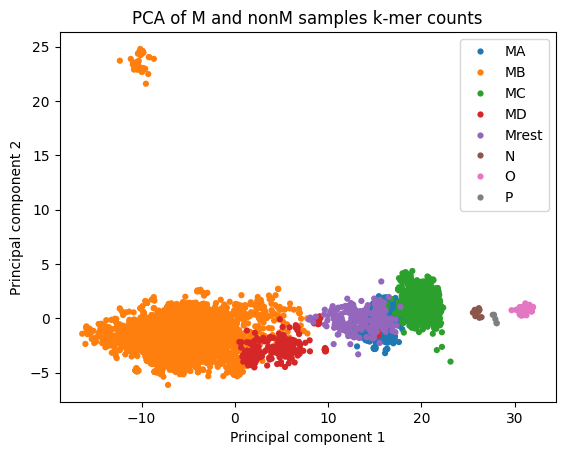

In [18]:
#Perform and plot PCA 
y_names = [name.split("_")[0] for name in sample_list]

pca = PCA(2)
X_pca = pd.DataFrame(pca.fit_transform(enriched_kmer_matrix[sample_list].T), index=sample_list)
fig, ax = plt.subplots()
ax.set_title('PCA of M and nonM samples k-mer counts')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
sns.scatterplot(x=X_pca[0], y=X_pca[1], hue=y_names, s=20, linewidth = 0)

#Uncomment the following line to save the plot as svg.
plt.savefig(f"../output/HIV/scenario4/{k}_PCA.svg", dpi = 600, format = "svg", bbox_inches='tight')

B_outliers = X_pca[X_pca[1] > 15].index.to_list()
subtype_sample_idx["Bmain"] = [sample for sample in subtype_sample_idx["MB"] if sample not in B_outliers]
subtype_sample_idx["Bout"] = B_outliers

In [19]:
# enriched_kmer_matrix = pd.read_csv(f"../output/HIV/scenario4/enriched_{k}mer_count_matrix.csv", index_col=0)
# enriched_kmer_matrix[sample_list] = enriched_kmer_matrix[sample_list].astype("uint8")
# enriched_kmer_stat_matrix = pd.read_csv(f"../output/HIV/scenario4/enriched_{k}mer_stat_matrix.csv", index_col=0)

In [54]:
subB_enriched_matrix = pd.read_csv("../output/HIV/subB/aligned_enriched_11mer_stat_matrix.csv", index_col=0)
enriched_kmer_matrix["B_outliers"] = subB_enriched_matrix["group"]
subB_enriched_kmers = {group:list(subB_enriched_matrix[subB_enriched_matrix["group"]==f"{group}_enriched"].index) for group in ["Bmain","Bout"]}

8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

In [55]:
for mm in range(3):
    mutations = {}
    n_pos = []
    ref_pos = []
    matches = []

    for kmer in enriched_kmer_matrix.index:
        
        alns = aligner.align(ref_seq, kmer)
        temp_n = 0
        temp_m = []
        temp_ref_pos = []

        for aln in alns:
                aln_length = len(aln.indices[1])
                adj_score = aln.score + ((k-aln_length)*-2)

                if adj_score>=k-3*mm:
                    temp_n += 1
                    temp_m.append(aln.counts()[1])
                    temp_ref_pos.append((aln.indices[0][0]+1,aln.indices[0][-1]+1))
                    if aln_length>=k:
                        for i in range(aln_length):
                            ref_nuc = aln[0][i]
                            kmer_nuc = aln[1][i]
                            if ref_nuc == "-":
                                mut_pos = aln.indices[0][i-1]+1
                            else:
                                mut_pos = aln.indices[0][i]+1
                            if ref_nuc != kmer_nuc:
                                mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                                if mutation in mutations.keys():
                                    mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                                else:
                                    mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
                    else:
                        for i in range(k):
                            mut_pos_0 = aln.indices[0][0]-aln.indices[1][0]+i
                            try:
                                ref_nuc = ref_seq[mut_pos_0]
                            except:
                                continue
                            kmer_nuc = kmer[i]
                            mut_pos = mut_pos_0+1
                            if ref_nuc != kmer_nuc:
                                mutation = f"{ref_nuc}{mut_pos}{kmer_nuc}"
                                if mutation in mutations.keys():
                                    mutations[mutation][kmer] = enriched_kmer_matrix.loc[kmer, "group"]
                                else:
                                    mutations[mutation] = {kmer:enriched_kmer_matrix.loc[kmer, "group"]}
        n_pos.append(temp_n)
        matches.append(temp_m)
        ref_pos.append(temp_ref_pos)

    enriched_kmer_matrix[f"{mm}_n_pos"] = n_pos
    enriched_kmer_matrix[f"{mm}_ref_pos"] = ref_pos
    enriched_kmer_matrix[f"{mm}_matches"] = matches
    enriched_kmer_matrix[f"{mm}_genes"] = enriched_kmer_matrix[f"{mm}_ref_pos"].apply(assign_gene_from_interval, args=[HIV_GENES])
    enriched_kmer_stat_matrix = enriched_kmer_matrix.drop(sample_list, axis=1)

    mutations = {mut:kmers for mut, kmers in mutations.items() if len(kmers) > k//2 and len(set(kmers.values())) == 1}

In [22]:
# enriched_kmer_stat_matrix.to_csv(f"../output/HIV/scenario4/aligned_enriched_{k}mer_stat_matrix.csv")

In [56]:
mutations_id = list(mutations.keys())
mutations_ref_nuc = [mutid[0] for mutid in mutations_id]
mutations_mut_nuc = [mutid[-1] for mutid in mutations_id]
mutations_ref_pos = [int(mutid[1:-1]) for mutid in mutations_id]
mutations_groups = [list(mutations[mutid].values())[0] for mutid in mutations_id]
mutations_kmres = [list(mutations[mutid].keys()) for mutid in mutations_id]
mut_df = pd.DataFrame({"ref_nuc":mutations_ref_nuc, "ref_pos":mutations_ref_pos, "mut_nuc":mutations_mut_nuc, "group":mutations_groups,"kmers":mutations_kmres}, index=mutations_id).sort_values("ref_pos")
for group in SAMPLE_GROUPS:
    mut_df[f"{group}_agg_freq"] = mut_df["kmers"].apply(portek.calc_agg_freq, args=(group_sample_idx[group], enriched_kmer_matrix))
mut_df["genes"] = mut_df["ref_pos"].apply(lambda pos: assign_gene_from_position(pos, HIV_GENES))
# mut_df.to_csv(f"../output/HIV/scenario4/enriched_mutations_variant1.csv")

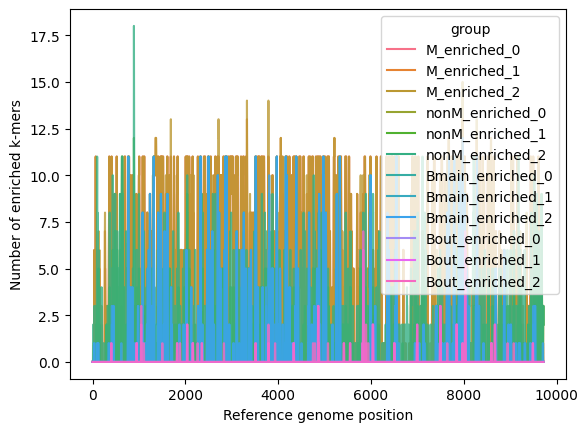

In [57]:
cov_columns = [f"M_enriched_{mm}" for mm in range(3)]
cov_columns.extend([f"nonM_enriched_{mm}" for mm in range(3)])
cov_columns.extend([f"Bmain_enriched_{mm}" for mm in range(3)])
cov_columns.extend([f"Bout_enriched_{mm}" for mm in range(3)])
kmer_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=cov_columns)

for kmer in enriched_kmer_stat_matrix.index:
    for mm in range(3):
        col = f"{enriched_kmer_stat_matrix.loc[kmer, 'group']}_{mm}"
        for position in enriched_kmer_stat_matrix.loc[kmer, f"{mm}_ref_pos"]:
            kmer_coverage.loc[position[0]:position[1], col] += 1

for kmer in subB_enriched_matrix.index:
    for mm in range(3):
        col = f"{enriched_kmer_stat_matrix.loc[kmer, 'B_outliers']}_{mm}"
        for position in enriched_kmer_stat_matrix.loc[kmer, f"{mm}_ref_pos"]:
            kmer_coverage.loc[position[0]:position[1], col] += 1

kmer_coverage_long = pd.melt(kmer_coverage, ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = kmer_coverage_long, x=kmer_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Number of enriched k-mers")
for line in ax.lines:
    line.set_alpha(0.8)

# plt.savefig(f"../output/HIV/scenario4/enriched_{k}mer_coverage_{mm}_mismatches.svg", format="svg", dpi=600)

In [25]:
binned = (kmer_coverage).rolling(window=20, step=20, min_periods=0).sum()

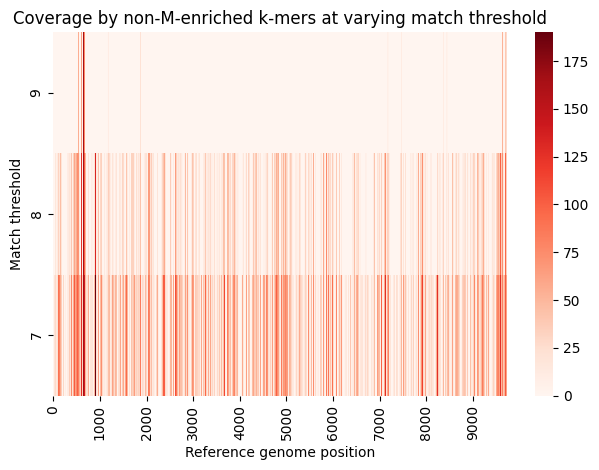

In [26]:
fig,ax = plt.subplots()
sns.heatmap(pd.DataFrame(binned[["nonM_enriched_0", "nonM_enriched_1","nonM_enriched_2"]]).T, cmap="Reds")
ax.set_xticks(range(0,500, 50), labels=range(0,10000,1000))
ax.set_yticklabels([9,8,7])
ax.set_title("Coverage by non-M-enriched k-mers at varying match threshold")
ax.set_ylabel("Match threshold")
ax.set_xlabel("Reference genome position")
fig.tight_layout()
plt.savefig(f"../output/HIV/scenario4/{k}_coverage_heatmap_nonM.svg", format="svg", dpi=600)
plt.show()

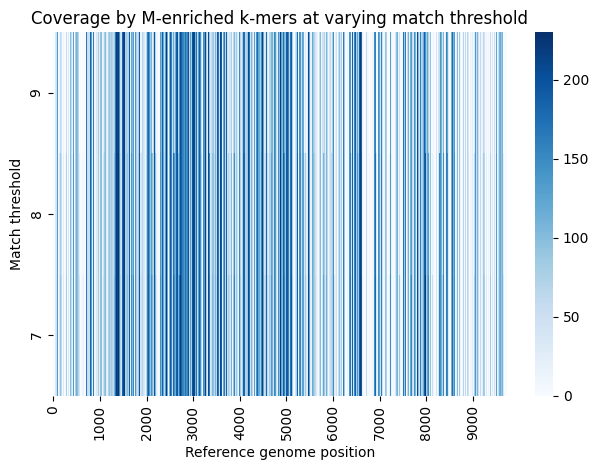

In [27]:
fig,ax = plt.subplots()
sns.heatmap(pd.DataFrame(binned[["M_enriched_0", "M_enriched_1","M_enriched_2"]]).T, cmap="Blues")
ax.set_xticks(range(0,500, 50), labels=range(0,10000,1000))
ax.set_yticklabels([9,8,7])
ax.set_title("Coverage by M-enriched k-mers at varying match threshold")
ax.set_ylabel("Match threshold")
ax.set_xlabel("Reference genome position")
fig.tight_layout()
plt.savefig(f"../output/HIV/scenario4/{k}coverage_heatmap_M.svg", format="svg", dpi=600)
plt.show()

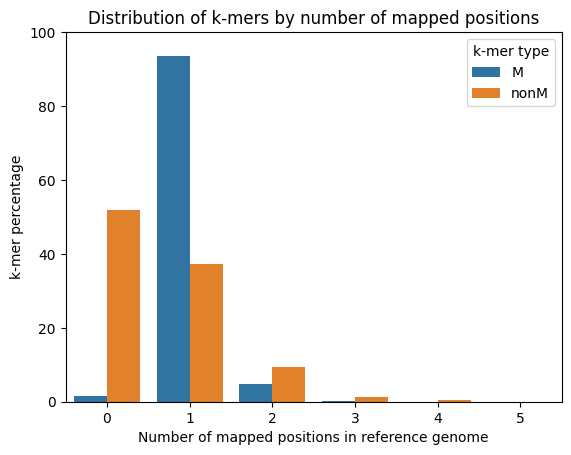

In [28]:
mm=2
M_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "M_enriched"].value_counts(f"{mm}_n_pos")/enriched_kmer_stat_matrix.value_counts('group')["M_enriched"]*100
nonM_dist = enriched_kmer_stat_matrix[enriched_kmer_stat_matrix["group"] == "nonM_enriched"].value_counts(f"{mm}_n_pos")/enriched_kmer_stat_matrix.value_counts('group')["nonM_enriched"]*100
dist = pd.concat([M_dist, nonM_dist], axis=1, keys=["M", "nonM"]).fillna(0).sort_index()
dist_longform = dist.melt(ignore_index=False, var_name="k-mer type")
fig, ax = plt.subplots()
sns.barplot(data = dist_longform, x = dist_longform.index, y="value", hue="k-mer type")
ax.set_title("Distribution of k-mers by number of mapped positions")
ax.set_ylabel("k-mer percentage")
ax.set_xlabel("Number of mapped positions in reference genome")
ax.set_ylim(0,100)

plt.savefig(f"../output/HIV/scenario4/enriched_{k}mer_map_distr_{mm}.svg", format="svg", dpi=600)

/tmp/ipykernel_82098/2921263775.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07423466036000526' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]
/tmp/ipykernel_82098/2921263775.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.762383392458284' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]
/tmp/ipykernel_82098/2921263775.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.726027397260274' has dtype incompatible with int64, please explicitly cast to a compati

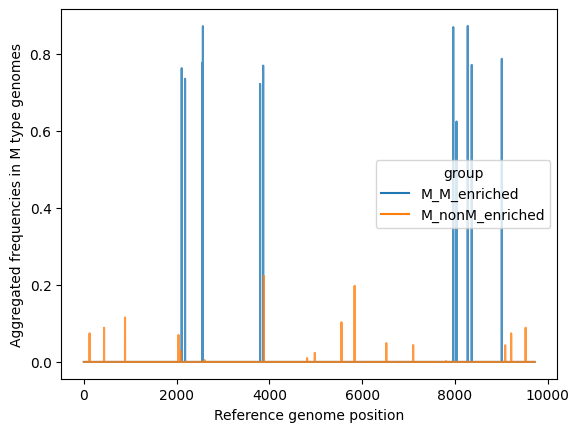

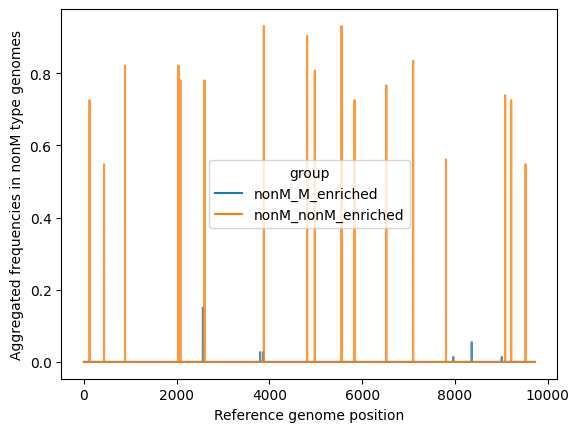

In [29]:
mut_coverage = pd.DataFrame(0, index=pd.RangeIndex(1,len(ref_seq)), columns=["M_M_enriched", "M_nonM_enriched", "nonM_M_enriched","nonM_nonM_enriched"])
for group in SAMPLE_GROUPS:
    for mutation in mut_df.index:
        mut_group = mut_df.loc[mutation, "group"]
        position = mut_df.loc[mutation, "ref_pos"]
        mut_coverage.loc[position, f"{group}_{mut_group}"] += mut_df.loc[mutation, f"{group}_agg_freq"]

M_mut_coverage_long = pd.melt(mut_coverage.iloc[:,:2], ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = M_mut_coverage_long, x=M_mut_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Aggregated frequencies in M type genomes")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/HIV/scenario4/mutaions_in_M_variant1.svg", format="svg", dpi=600)

nonM_mut_coverage_long = pd.melt(mut_coverage.iloc[:,2:], ignore_index=False, var_name="group")

fig, ax = plt.subplots()
sns.lineplot(data = nonM_mut_coverage_long, x=nonM_mut_coverage_long.index, y="value", hue="group")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Aggregated frequencies in nonM type genomes")
for line in ax.lines:
    line.set_alpha(0.8)

plt.savefig(f"../output/HIV/scenario4/mutaions_in_nonM_variant1.svg", format="svg", dpi=600)

In [30]:
reference_free_coverage = pd.DataFrame(0,index = pd.RangeIndex(1,11000), columns=SAMPLE_GROUPS, dtype=float)
enriched_kmer_pos_matrix = pd.DataFrame([[[] for _ in range(len(sample_list))]], index = enriched_kmer_stat_matrix.index, columns=sample_list)
enriched_kmer_pos_matrix.index = enriched_kmer_pos_matrix.index.map(lambda seq: portek.encode_kmer(seq))
enriched_kmer_pos_matrix

,MA_A.CD.1987.P4039.MH705157,MA_A.CH.2003.HIV_CH_BID-V3538_2003.JQ403028,MA_A.ZA.2004.04ZASK162B1.DQ396400,MA_A1.AU.2003.PS1044_Day0.DQ676872,MA_A1.AU.2004.PS1044_Day177.DQ676873,MA_A1.BG.2009.V_09_007.MH746259,MA_A1.BG.2009.V_09_008.MH746258,MA_A1.BG.2009.V_09_017.MH746253,MA_A1.CD.1987.2106.MH705158,MA_A1.CD.1987.70641.MH705151,...,O_O.US.-.I_2478B.AB485668,O_O.US.-.I_2478B.AB485669,O_O.US.1997.97US08692A.AY169805,O_O.US.1999.99USTWLA.AY169814,O_O.US.2010.LTNP.JN571034,P_P.CM.2006.U14788.HQ179987,P_P.CM.2006.U14788.JA446000,P_P.FR.-.DEPXXFR006.KY953207,P_P.FR.2006.RBF168.GQ328744,P_P.FR.2009.RBF168.GU111555
2097352,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2637450,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
3793182,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
2227529,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
4156,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260578,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
770816,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
597010,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
3449100,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]


In [31]:
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_pos.pkl")

counter = 0
for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    pos_dict = {f"{sample_name}": temp_dict}
    temp_df = pd.DataFrame(pos_dict, index=temp_dict.keys())
    enriched_kmer_pos_matrix.update(temp_df)
    
    counter +=1
    print(counter, end = "\r", flush=True)

enriched_kmer_pos_matrix.index = enriched_kmer_pos_matrix.index.map(lambda id: portek.decode_kmer(id, k))
enriched_kmer_pos_matrix

,MA_A.CD.1987.P4039.MH705157,MA_A.CH.2003.HIV_CH_BID-V3538_2003.JQ403028,MA_A.ZA.2004.04ZASK162B1.DQ396400,MA_A1.AU.2003.PS1044_Day0.DQ676872,MA_A1.AU.2004.PS1044_Day177.DQ676873,MA_A1.BG.2009.V_09_007.MH746259,MA_A1.BG.2009.V_09_008.MH746258,MA_A1.BG.2009.V_09_017.MH746253,MA_A1.CD.1987.2106.MH705158,MA_A1.CD.1987.70641.MH705151,...,O_O.US.-.I_2478B.AB485668,O_O.US.-.I_2478B.AB485669,O_O.US.1997.97US08692A.AY169805,O_O.US.1999.99USTWLA.AY169814,O_O.US.2010.LTNP.JN571034,P_P.CM.2006.U14788.HQ179987,P_P.CM.2006.U14788.JA446000,P_P.FR.-.DEPXXFR006.KY953207,P_P.FR.2006.RBF168.GQ328744,P_P.FR.2009.RBF168.GU111555
GAAAAAATAGA,[],[],[],[],[],[],[],[],[],[],...,"[2690, 4241]","[2690, 4241]","[2085, 3636]","[2117, 3668]",[4160],[2105],[2105],[2752],[2095],[2670]
GGAATTGGAGG,[2397],[1602],[1838],[1605],[1605],[1624],[1597],"[1609, 3382]",[2398],"[2384, 4157]",...,[],[],[],[],[],[],[],[],[],[]
TGCTGACACTG,[],[],[],[],[],[],[],[],[],[],...,"[354, 9653]","[354, 9653]",[9009],[],"[275, 307]",[9052],[9052],"[442, 9657]",[],"[364, 9572]"
GACTTTCCAGC,[],[],[],[],[],[],[],[],[],[],...,"[400, 9699]","[400, 9699]",[9055],"[9013, 9040]",[289],[],[],[],[],[]
AAAACAAATTA,[4871],[4076],[4312],[],[],[4098],[4071],[6732],[4878],[],...,[],[],[],[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AATTTGCTGAG,[],[],[7339],[7122],[7122],[7137],[7120],[7132],[7852],[],...,[],[],[],[],[],[],[],[],[],[]
AGTTAATAAAA,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],[]
AGCACTAACAG,[3410],[],[],[2618],[2618],"[1872, 2637]","[1845, 2610]",[2622],[],[3397],...,[],[],[],[],[],[],[],[],[],[]
TCAGGACAATA,[],[],[],[],[],[],[],[],[],[],...,[8684],[8684],[8040],[],[],[],[],[],[],[]


In [ ]:
counter = 0
for group in SAMPLE_GROUPS:
    for kmer in enriched_kmers[group]:
        for sample in group_sample_idx[group]:
            for position in enriched_kmer_pos_matrix.loc[kmer, sample]:
                reference_free_coverage.loc[position+k-1, group] += 1/len(group_sample_idx[group])
        counter+=1
        print(counter, end = "\r", flush=True)

reference_free_coverage

<Axes: >

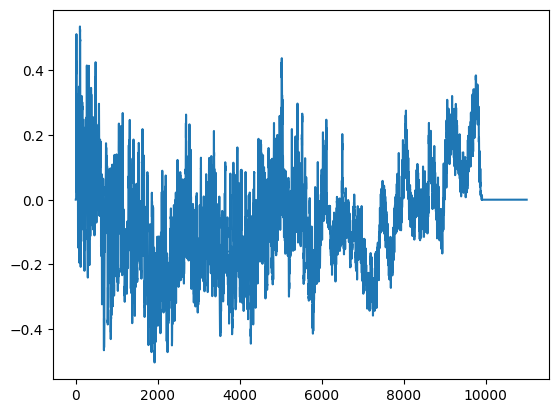

In [47]:
sns.lineplot(reference_free_coverage["nonM"]-reference_free_coverage["M"])

In [32]:
reference_free_coverage_coverage_B = pd.DataFrame(0,index = pd.RangeIndex(1,11000), columns=["Bmain","Bout"], dtype=float)
counter = 0
for group in ["Bmain", "Bout"]:
    for kmer in subB_enriched_kmers[group]:
        for sample in subtype_sample_idx[group]:
            for position in enriched_kmer_pos_matrix.loc[kmer, sample]:
                reference_free_coverage_coverage_B.loc[position+k-1, group] += 1/len(subtype_sample_idx[group])
        counter+=1
        print(counter, end = "\r", flush=True)

reference_free_coverage_coverage_B

,Bmain,Bout
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
...,...,...
10995,0.0,0.0
10996,0.0,0.0
10997,0.0,0.0
10998,0.0,0.0


In [33]:
reference_free_coverage_coverage_B["diff"] = reference_free_coverage_coverage_B["Bout"]-reference_free_coverage_coverage_B["Bmain"]

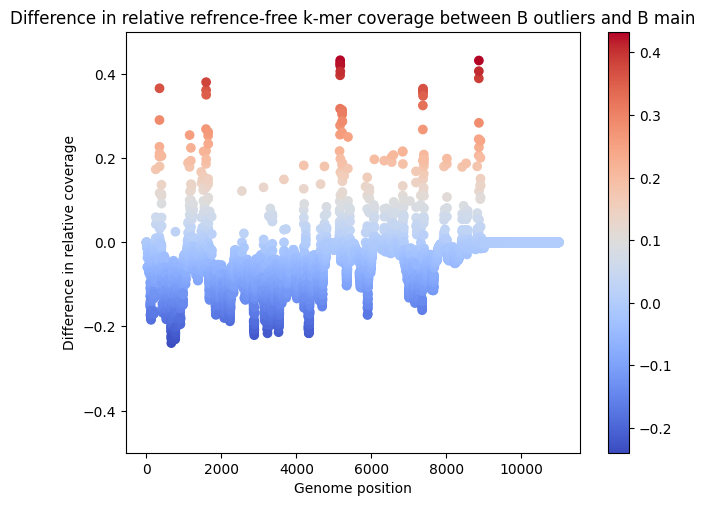

In [58]:
fig, ax = plt.subplots()
fig.tight_layout()
ax.set_title("Difference in relative refrence-free k-mer coverage between B outliers and B main")
ax.set_ylim(-0.5,0.5)
ax.set_xlabel("Genome position")
ax.set_ylabel("Difference in relative coverage")
plt.scatter(reference_free_coverage_coverage_B.index, reference_free_coverage_coverage_B["diff"], c=reference_free_coverage_coverage_B["diff"], cmap="coolwarm", edgecolors=None)
plt.clim(reference_free_coverage_coverage_B["diff"].min(), reference_free_coverage_coverage_B["diff"].max())
plt.colorbar(ax=ax)


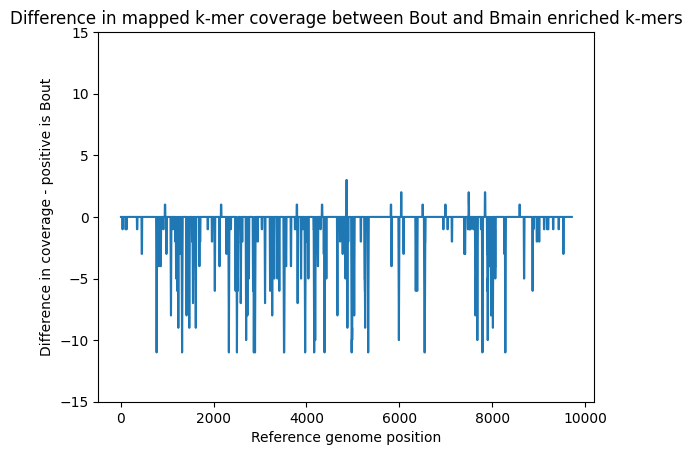

In [73]:
kmer_coverage["Bdiff_0"] = kmer_coverage["Bout_enriched_0"] - kmer_coverage["Bmain_enriched_0"]
fig, ax = plt.subplots()
ax.set_ylim(-15,15)
ax.set_title("Difference in mapped k-mer coverage between Bout and Bmain enriched k-mers")
ax.set_xlabel("Reference genome position")
ax.set_ylabel("Difference in coverage - positive is Bout")
sns.lineplot(kmer_coverage["Bdiff_0"])
plt.savefig("../output/HIV/scenario4/Bout_mapped_coverage_diference.svg", dpi=600, format="svg", bbox_inches = "tight")

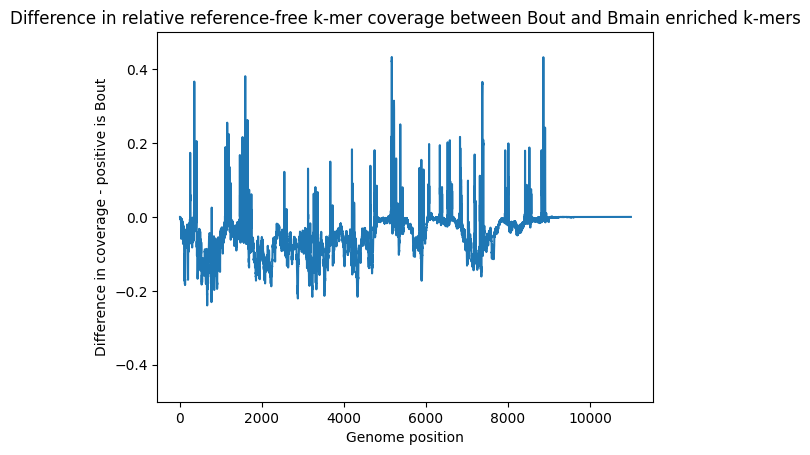

In [149]:
fig, ax = plt.subplots()
ax.set_ylim(-0.5,0.5)
ax.set_title("Difference in relative reference-free k-mer coverage between Bout and Bmain enriched k-mers")
ax.set_xlabel("Genome position")
ax.set_ylabel("Difference in coverage - positive is Bout")
sns.lineplot(reference_free_coverage_coverage_B["diff"])
plt.savefig("../output/HIV/scenario4/Bout_ref_free_coverage_diference.svg", dpi=600, format="svg", bbox_inches = "tight")


In [139]:
peak_indices, peak_dict = find_peaks(reference_free_coverage_coverage_B["diff"], height=(None, None))
top_peaks = np.argpartition(peak_dict["peak_heights"], -6)[-6:]
top_peak_kmers = {peak+1:set() for peak in peak_indices[top_peaks]}
top_peak_kmers

{7376: set(), 350: set(), 1593: set(), 5169: set(), 5167: set(), 8864: set()}

In [157]:
for kmer in subB_enriched_kmers["Bout"]:
    for sample in subtype_sample_idx["Bout"]:
        for peak in top_peak_kmers.keys():
            for pos in enriched_kmer_pos_matrix.loc[kmer, sample]:
                if pos <= peak <= pos+k-1:
                    top_peak_kmers[peak].add(kmer)

top_peak_kmers


{7376: {'AAAACTCATCT',
  'AAACTCATCTG',
  'AACTCATCTGC',
  'ACTCATCTGCA',
  'ATCTGCACCAC',
  'CAGGCCAGACA',
  'CATCTGCACCA',
  'CTCATCTGCAC',
  'CTGTGGAAAGG',
  'GAAAACTCATC',
  'TCATCTGCACC',
  'TCTGCACCACT',
  'TGTGGAAAGGT'},
 350: {'ATTGTGTACAT', 'CTATTGTGTAC', 'TATTGTGTACA', 'TCTATTGTGTA'},
 1593: {'AATCACTCTTT',
  'AGAAGAAATGG',
  'AGAGACAGCAG',
  'CAAATCACTCT',
  'CCCTCAAATCA',
  'CCTCAAATCAC',
  'CTCAAATCACT',
  'TCAAATCACTC'},
 5169: {'AAATGGATCCA',
  'AAGAAATGGAT',
  'AATGGATCCAG',
  'AGAAATGGATC',
  'ATGGATCCAGT',
  'CAGAGGAGAGC',
  'GAAATGGATCC',
  'GATCCAGTAGA',
  'GGATCCAGTAG',
  'TGGATCCAGTA'},
 5167: {'AAATGGATCCA',
  'AAGAAATGGAT',
  'AATGGATCCAG',
  'AGAAATGGATC',
  'ATGGATCCAGT',
  'CAGAGGAGAGC',
  'GAAATGGATCC',
  'GATCCAGTAGA',
  'GGATCCAGTAG',
  'TGGATCCAGTA'},
 8864: {'CGGGGAGTGGC',
  'CTTTCTGCTTG',
  'GCTTTCTGCTT',
  'TCTGCTTGTAC',
  'TTCTGCTTGTA',
  'TTTCTGCTTGT'}}

In [158]:
enriched_kmer_stat_matrix.loc[list(top_peak_kmers[1593])]

,M_freq,M_avg,nonM_freq,nonM_avg,M-nonM_err,M-nonM_p-value,-log10_M-nonM_p-value,RMSE,group,exclusivity,...,0_genes,1_n_pos,1_ref_pos,1_matches,1_genes,2_n_pos,2_ref_pos,2_matches,2_genes,B_outliers
CAAATCACTCT,0.604388,0.604388,0.027397,0.027397,0.576991,3.184677e-26,25.496935,0.576991,M_enriched,non-exclusive,...,,0,[],[],,0,[],[],,Bout_enriched
AGAAGAAATGG,0.117002,0.117264,0.698630,0.698630,-0.581366,8.579337e-31,30.066546,0.581366,nonM_enriched,non-exclusive,...,,2,"[(1818, 1827), (2351, 2360)]","[10, 10]","gag, pol",2,"[(1818, 1827), (2351, 2360)]","[10, 10]","gag, pol",Bout_enriched
CTCAAATCACT,0.604454,0.604585,0.027397,0.027397,0.577188,3.177136e-26,25.497964,0.577188,M_enriched,non-exclusive,...,,0,[],[],,0,[],[],,Bout_enriched
TCAAATCACTC,0.604454,0.604454,0.027397,0.027397,0.577057,3.148235e-26,25.501933,0.577057,M_enriched,non-exclusive,...,,0,[],[],,0,[],[],,Bout_enriched
AGAGACAGCAG,0.269544,0.282157,0.931507,0.931507,-0.649349,9.178593e-34,33.037224,0.649349,nonM_enriched,non-exclusive,...,,0,[],[],,1,"[(4747, 4755)]",[9],pol,Bout_enriched
CCCTCAAATCA,0.604257,0.604323,0.027397,0.027397,0.576925,3.273735e-26,25.484957,0.576925,M_enriched,non-exclusive,...,,0,[],[],,1,"[(8599, 8607)]",[9],"rev, env",Bout_enriched
CCTCAAATCAC,0.604388,0.604388,0.027397,0.027397,0.576991,3.184677e-26,25.496935,0.576991,M_enriched,non-exclusive,...,,0,[],[],,0,[],[],,Bout_enriched
AATCACTCTTT,0.604388,0.604388,0.027397,0.027397,0.576991,3.184677e-26,25.496935,0.576991,M_enriched,non-exclusive,...,,0,[],[],,1,"[(2260, 2268)]",[9],"gag, pol",Bout_enriched


In [178]:
np.mean(enriched_kmer_pos_matrix.loc["CCCTCAAATCA", subtype_sample_idx["Bout"]].sum())

1603.5250338294993

In [180]:
enriched_kmer_pos_matrix.loc[list(top_peak_kmers[1593]), subtype_sample_idx["Bout"]]

,MB_B.US.2016.605_wk-2_Q10_B16.MW060142,MB_B.US.2016.605_wk-2_Q10_M24.MW060151,MB_B.US.2016.9252_W0_10A20_S28.MK115694,MB_B.US.2016.9252_W0_10H11_S29.MK115695,MB_B.US.2016.9252_W0_10H17_S30.MK115696,MB_B.US.2016.9252_W0_10K15_S31.MK115697,MB_B.US.2016.9252_W0_10N5_S32.MK115698,MB_B.US.2016.9252_W0_11B7_S34.MK115700,MB_B.US.2016.9252_W0_11D14_S35.MK115701,MB_B.US.2016.9252_W0_11I17_S36.MK115702,...,MB_B.US.2018.9252_W12_6N16.MN090627,MB_B.US.2018.9252_W12_6N20.MN090628,MB_B.US.2018.9252_W12_6N4.MN090629,MB_B.US.2018.9252_W12_6N7.MN090630,MB_B.US.2018.9252_W12_6O10.MN090631,MB_B.US.2018.9252_W12_6O13.MN090632,MB_B.US.2018.9252_W12_6O16.MN090633,MB_B.US.2018.9252_W12_6O5.MN090634,MB_B.US.2018.9252_W12_6O6.MN090635,MB_B.US.2018.9252_W12_6P1.MN090636
CAAATCACTCT,[1583],[1583],[1640],[1587],[1768],[1622],[1585],[1599],[1595],[1746],...,[1583],[1639],[1639],[1539],[1620],[1583],[1585],[1640],[1586],[1587]
AGAAGAAATGG,[1678],[1678],[1735],[1682],[1863],[1717],[1680],[1694],[1690],[1841],...,[1678],[1734],[1734],[1634],[1715],[1678],[1680],[1735],[1681],[1682]
CTCAAATCACT,[1581],[1581],[1638],[1585],[1766],[1620],[1583],[1597],[1593],[1744],...,[1581],[1637],[1637],[1537],[1618],[1581],[1583],[1638],[1584],[1585]
TCAAATCACTC,[1582],[1582],[1639],[1586],[1767],[1621],[1584],[1598],[1594],[1745],...,[1582],[1638],[1638],[1538],[1619],[1582],[1584],[1639],[1585],[1586]
AGAGACAGCAG,[1517],[1517],[1574],[1521],[1702],[1556],[1519],[1533],[1529],[1680],...,[1517],[1573],[1573],[1473],[1554],[1517],[1519],[1574],[1520],[1521]
CCCTCAAATCA,[1579],[1579],[1636],[1583],[1764],[1618],[1581],[1595],[1591],[1742],...,[1579],[1635],[1635],[1535],[1616],[1579],[1581],[1636],[1582],[1583]
CCTCAAATCAC,[1580],[1580],[1637],[1584],[1765],[1619],[1582],[1596],[1592],[1743],...,[1580],[1636],[1636],[1536],[1617],[1580],[1582],[1637],[1583],[1584]
AATCACTCTTT,[1585],[1585],[1642],[1589],[1770],[1624],[1587],[1601],[1597],[1748],...,[1585],[1641],[1641],[1541],[1622],[1585],[1587],[1642],[1588],[1589]


In [195]:
alns = aligner.align(ref_seq, "CCCTCAAATCACT")

for aln in alns:
    print(aln)

target         8598 CCCTCAAAT 8607
                  0 |||||||||    9
query             0 CCCTCAAAT    9

